In [2]:
import sys, os
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.insert(1, os.path.abspath(os.pardir))
import CONFIG

%reload_ext autoreload
%autoreload 2

In [3]:
from IPython.display import Image

import pandas as pd
import numpy as np
import cv2
import os, re

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import KFold

import torch

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt 
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [4]:
DATA_DIR = CONFIG.CFG.DATA.BASE
MODELS_OUT_DIR = CONFIG.CFG.DATA.MODELS_OUT

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
ON_CPU = DEVICE == torch.device('cpu')
TRAIN_BATCH_SIZE = 4 if ON_CPU else 12
VALID_BATCH_SIZE = 4 if ON_CPU else 6
NUM_EPOCHS = 5 if ON_CPU else 5
LEARNING_RATE = 0.005
NEW_COLUMNS = ['x', 'y', 'w', 'h']

In [5]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

UNIQ_TRAIN_IMAGE_IDS = train_df["image_id"].unique()

train_df.shape, test_df.shape

((147793, 5), (10, 2))

In [6]:
# separate the bboxes into new columns
sep_bboxes = np.stack(train_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, new_column in enumerate(NEW_COLUMNS):
    train_df[new_column] = sep_bboxes[:, i]
train_df.drop(columns=['bbox'], inplace=True)
train_df.head()


,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [7]:
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    assert image is not None, f"IMAGE NOT FOUND AT {image_path}"
    return image

In [8]:
def draw_bboxes(boxes, image, color=(255,0,0)):
    for box in boxes:
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 3
        )
    return image

In [9]:
def plot_random_train_sample():
    image_id = np.random.choice(UNIQ_TRAIN_IMAGE_IDS)
    plt.title(image_id)
    image = load_image(os.path.join(DATA_DIR, "train", f"{image_id}.jpg"))
    bboxes = (train_df[train_df["image_id"] == image_id][NEW_COLUMNS]).to_numpy()
    bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]
    plt.imshow(draw_bboxes(bboxes, image))

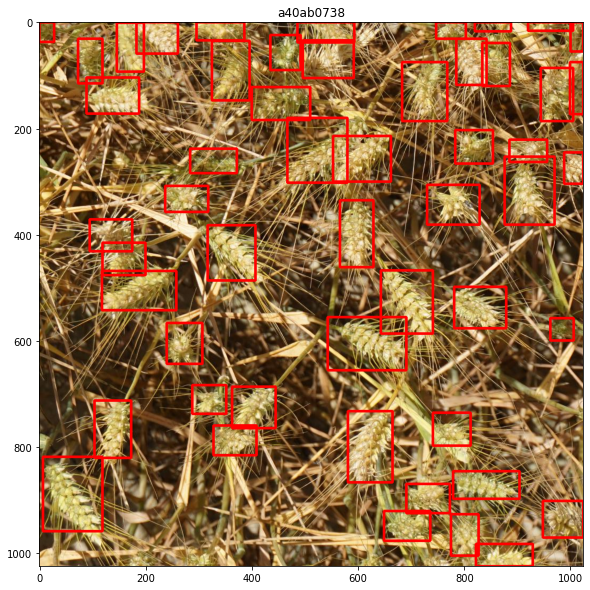

In [10]:
plot_random_train_sample()

In [11]:
class WheatDataset(Dataset):
    def __init__(self, df, image_dir, transforms=None):
        super().__init__()

        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_ids = df['image_id'].unique()

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = load_image(os.path.join(self.image_dir, f"{image_id}.jpg")).astype(np.float32)
        image /= 255.0

        records = self.df[self.df['image_id'] == image_id]

        boxes = records[NEW_COLUMNS].values
        area = boxes[:, 2] * boxes[:, 3]
        area = torch.as_tensor(area, dtype=torch.float32)

        # change the co-ordinates into expected [x, y, x+w, y+h] format
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # since all the boxes are wheat, it's all 1s
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        # consider iscrowd false for all the boxes
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            aug = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = aug['image']
            target['boxes'] = torch.as_tensor(aug['bboxes'], dtype=torch.float32)

        return image, target

In [12]:
def get_train_transforms():
    return A.Compose([
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.9),
        A.HorizontalFlip(0.5),
        A.VerticalFlip(0.5),
        ToTensorV2(p=1.0)
    ],
    p=1.0, 
    bbox_params=A.BboxParams(
        format='pascal_voc',
        min_area=0,
        min_visibility=0,
        label_fields=['labels']
    ))

def get_valid_transforms():
    return A.Compose([
        ToTensorV2(p=1.0)
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc',
        min_area=0,
        min_visibility=0,
        label_fields=['labels']
    ))

In [13]:
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # replace the end predictor with new FastRCNNPredictor with 2 classes (background(0) + wheat(1) (background is always 0))
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features, num_classes=2)
    return model

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
def train_epoch(model, optimizer, train_data_loader):
    losses = AverageMeter()
    for b_idx, (images, targets) in enumerate(train_data_loader):
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        losses.update(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b_idx % 50 == 0:
            print(f"Epoch: {epoch} Batch Index: {b_idx} Loss: {loss.item()} LR: {optimizer.param_groups[0]['lr']}")
    print(f"End of epoch {epoch}. Loss: {losses.avg}")

In [17]:
def validate_epoch(model, valid_data_loader):
    losses = AverageMeter()
    with torch.no_grad():
        for _, (images, targets) in enumerate(valid_data_loader):
            # move the images and targets to device
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            val_loss_dict = model(images, targets)
            val_loss = sum(loss for loss in val_loss_dict.values())

            losses.update(val_loss.item())
    print(f"Validation Loss: {losses.avg}\n")
    return losses.avg

In [18]:
kf = KFold()

In [19]:
# train 5 folds
for idx, (train_ids, valid_ids) in enumerate(kf.split(UNIQ_TRAIN_IMAGE_IDS)):
    ids_train = [UNIQ_TRAIN_IMAGE_IDS[k] for k in train_ids]
    ids_valid = [UNIQ_TRAIN_IMAGE_IDS[k] for k in valid_ids]

    df_train = train_df[train_df['image_id'].isin(ids_train)]
    df_valid = train_df[train_df['image_id'].isin(ids_valid)]

    train_dataset = WheatDataset(df_train, os.path.join(DATA_DIR, "train"), get_train_transforms())
    valid_dataset = WheatDataset(df_valid, os.path.join(DATA_DIR, "train"), get_valid_transforms())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=1,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        num_workers=1,
        collate_fn=collate_fn
    )

    model = get_model()
    model.to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    best_val = float('inf')
    model.train()
    for epoch in range(NUM_EPOCHS):
        train_epoch(model, optimizer, train_data_loader)
        val_loss = validate_epoch(model, valid_data_loader)
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), os.path.join(MODELS_OUT_DIR, f"best_model_{idx}.pth"))
        else:
            if lr_scheduler is not None:
                lr_scheduler.step()
    print(f"End of fold {idx}\n")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
Epoch: 0 Batch Index: 0 Loss: 4.571288108825684 LR: 0.005
Epoch: 0 Batch Index: 50 Loss: 0.7582309246063232 LR: 0.005
Epoch: 0 Batch Index: 100 Loss: 0.6986425518989563 LR: 0.005
Epoch: 0 Batch Index: 150 Loss: 0.7315880656242371 LR: 0.

In [20]:
CONFIG.upload_to_kaggle("gwdresnet50cv", "GWD ResNet-50 CV", new=True)